In [375]:
from tqdm import tqdm
import sys
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
from linearmodels import PanelOLS

# features

In [376]:
trains = pd.read_pickle("data/MAD_BAR_trains_v2.pkl")

In [377]:
#trains = trains.loc[trains["train_id"] != trains.loc[64265, "train_id"]]

<AxesSubplot:>

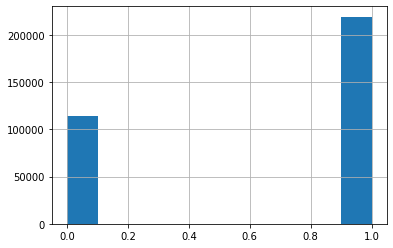

In [378]:
(trains["Turista_Promo_price"] - (trains["Turista_Promo +_price"] - 6)).round().hist()

In [103]:
data = (
    trains.groupby(["train_id", "days_till_dep"])
    .agg(
        mean_econ_price=("Turista_Promo_price", np.nanmean),
        mean_first_price=("Preferente_Promo_price", np.nanmean),
        mean_price=("price", np.nanmean),
        max_econ_seats=("Turista_Promo_seats", max),
        min_econ_seats=("Turista_Promo_seats", min),
        mean_econ_seats=("Turista_Promo_seats", "mean"),
        max_first_seats=("Preferente_Promo_seats", max),
        min_first_seats=("Preferente_Promo_seats", min),
        mean_first_seats=("Preferente_Promo_seats", "mean"),
        departure=("departure", "first"),
        duration=("duration", "first"),
    )
    .dropna(subset=["max_econ_seats", "min_econ_seats"])
    .reset_index()
)

In [171]:
data = (
    trains.groupby(["train_id", "days_till_dep"])
    .agg(
        mean_econ_price=("Turista_Promo +_price", np.nanmean),
        mean_first_price=("Preferente_Promo +_price", np.nanmean),
        max_econ_seats=("Turista_Promo +_seats", max),
        min_econ_seats=("Turista_Promo +_seats", min),
        mean_econ_seats=("Turista_Promo +_seats", "mean"),
        max_first_seats=("Preferente_Promo +_seats", max),
        min_first_seats=("Preferente_Promo +_seats", min),
        mean_first_seats=("Preferente_Promo +_seats", "mean"),
        departure=("departure", "first"),
        duration=("duration", "first"),
    )
    .dropna(subset=["max_econ_seats", "min_econ_seats"])
    .reset_index()
)

In [172]:
data["econ_seats_sold"] = (data["max_econ_seats"] - data["min_econ_seats"]).round()
data["first_seats_sold"] = data["max_first_seats"] - data["min_first_seats"].round()

In [173]:
data["weekday"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday()
)
data["depart_month"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month
)
data["depart_hour"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour
)
# only kan, feb, march
data = data.loc[data["depart_month"] < 4].reset_index(drop=True)

In [174]:
data["day_part"] = data["depart_hour"] > 12
data["ln_price"] = np.log(data["mean_econ_price"] + 1)
data["ln_econ_seat"] = np.log(data["econ_seats_sold"] + 1)
data["const"] = 1

In [175]:
# filter for those trains, that data is availabel for more than 15 days
id_obs = data.groupby("train_id")["days_till_dep"].count().reset_index()
train_ids = list(id_obs.loc[id_obs["days_till_dep"] > 15]["train_id"].values)

data = data.loc[data["train_id"].isin(train_ids)].reset_index()

In [176]:
#filter for seats sold on an individual day is less than 100
data = data.loc[data["econ_seats_sold"] < 100].reset_index()

In [177]:
# filter for trains, whos data is close to departure day by min(days until departure) < 3)

min_days_until_dep = data.groupby("train_id")["days_till_dep"].min().reset_index()
data = data.loc[
    data["train_id"].isin(
        list(
            min_days_until_dep.loc[min_days_until_dep["days_till_dep"] < 3]["train_id"]
        )
    )
]

In [178]:
data["price_change"] = (
    data.sort_values(by=["train_id", "days_till_dep"], ascending=False)
    .groupby("train_id")["mean_econ_price"]
    .transform("diff")
)

data["price_change_percentage"] = (data["price_change"] / data["mean_price"]).round(3)

data["price_change_direction"] = np.where(
    data["price_change_percentage"] > 0,
    1,
    np.where(data["price_change_percentage"] < 0, -1, 0),
)

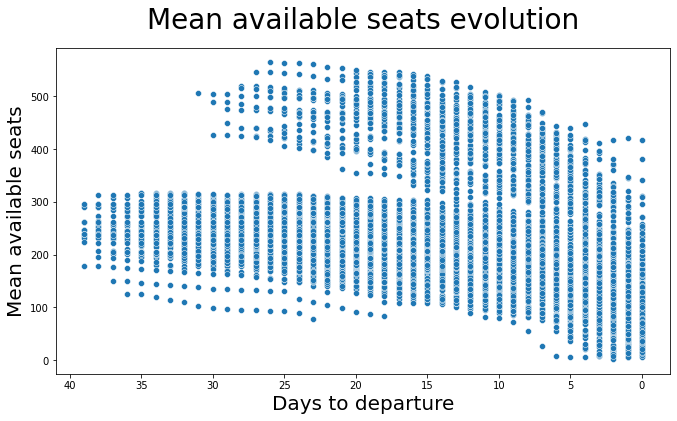

In [180]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    estimator="mean",
    #hue="train_id",
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

In [182]:
# differentiate big and small trains, work with small
max_seats = data.groupby("train_id")["mean_econ_seats"].max().reset_index()


data_small =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] < 350]["train_id"])
    )
]

data_big =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] > 350]["train_id"])
    )
]

In [183]:
data = data_small

In [184]:
len(data["train_id"].unique())

273

In [185]:
data.to_pickle("data/MAD_BAR_features_v2.pkl")

In [ ]:
price_changed = data.groupby("train_id")["price_change"].sum().reset_index().round(2)
price_changed["price_change"].value_counts()

In [ ]:
data["price_change_direction"] = np.where(
    data["price_change_percentage"] > 0,
    1,
    np.where(data["price_change_percentage"] < 0, -1, 0),
)

## Plots

In [384]:
data = pd.read_pickle("data/MAD_BAR_features_v2.pkl")

In [381]:
data = data.loc[data["train_id"]!= train_ids[0]].reset_index(drop=True)
data = data.loc[
    data["train_id"]
    != data.loc[data["price_change_percentage"] < -1]["train_id"].unique()[0]
].reset_index(drop=True)

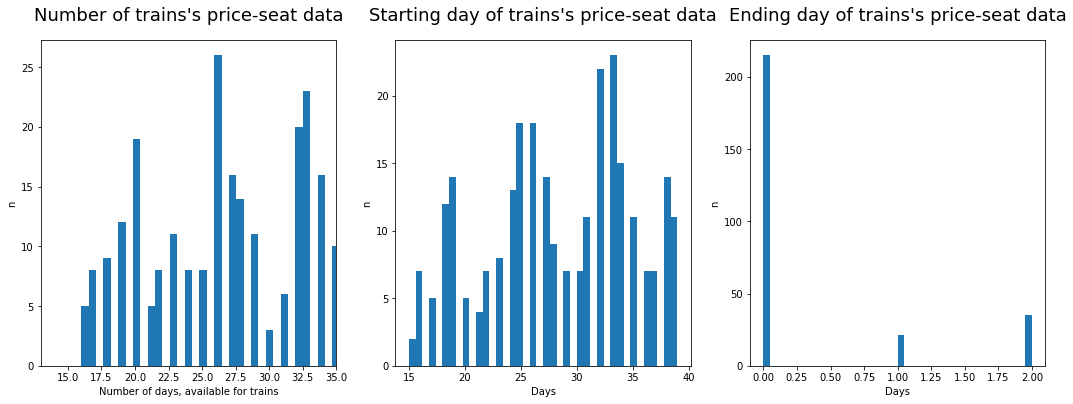

In [310]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "days_till_dep"
]

plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 3, 1)
ax1.set_xlim(13, 35)
# ax1.set_ylim(0,50)
ax1.hist(figdata.count(), bins=40)
plt.xlabel("Number of days, available for trains", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title("Number of trains's price-seat data", fontsize=18, y=1.04)


ax2 = plt.subplot(1, 3, 2)
# ax2.set_xlim(35, 110)
# ax2.set_ylim(0, 0.14)
ax2.hist(figdata.last(), bins=40)
plt.xlabel("Days", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title(
    "Starting day of trains's price-seat data", fontsize=18, y=1.04
)


ax3 = plt.subplot(1, 3, 3)
# ax3.set_xlim(35, 110)
# ax3.set_ylim(0, 0.14)
ax3.hist(figdata.first(), bins=40)
plt.xlabel("Days", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title(
    "Ending day of trains's price-seat data", fontsize=18, y=1.04
)

plt.savefig("figures/days_plots", dpi=300)

plt.show()

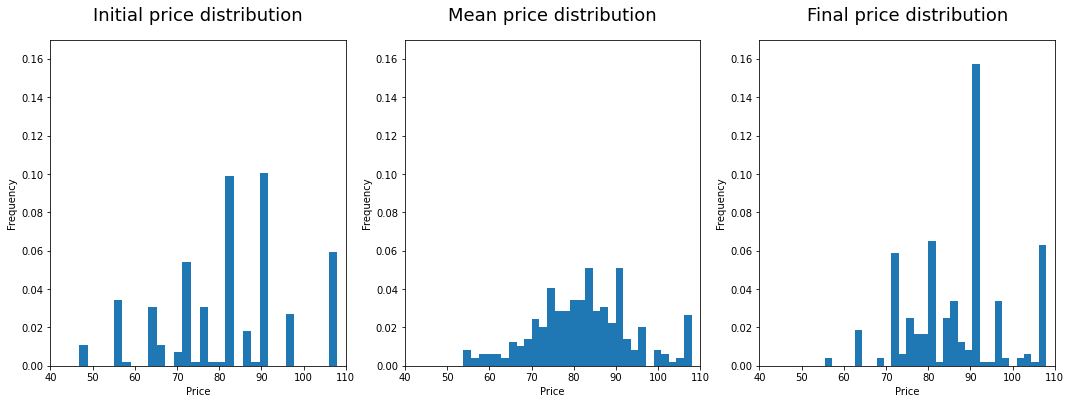

In [197]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "mean_econ_price"
]

plt.figure(figsize=(18, 6))

xlim_min = 40
xlim_max = 110
ylim_min = 0
ylim_max = 0.17

ax1 = plt.subplot(1, 3, 1)
ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
ax1.hist(figdata.last(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Initial price distribution", fontsize=18, y=1.04)


ax2 = plt.subplot(1, 3, 2)
ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.hist(figdata.mean(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Mean price distribution", fontsize=18, y=1.04)


ax3 = plt.subplot(1, 3, 3)
ax3.set_xlim(xlim_min, xlim_max)
ax3.set_ylim(ylim_min, ylim_max)
ax3.hist(figdata.first(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Final price distribution", fontsize=18, y=1.04)

plt.savefig("figures/price_distributions", dpi=300)

plt.show()

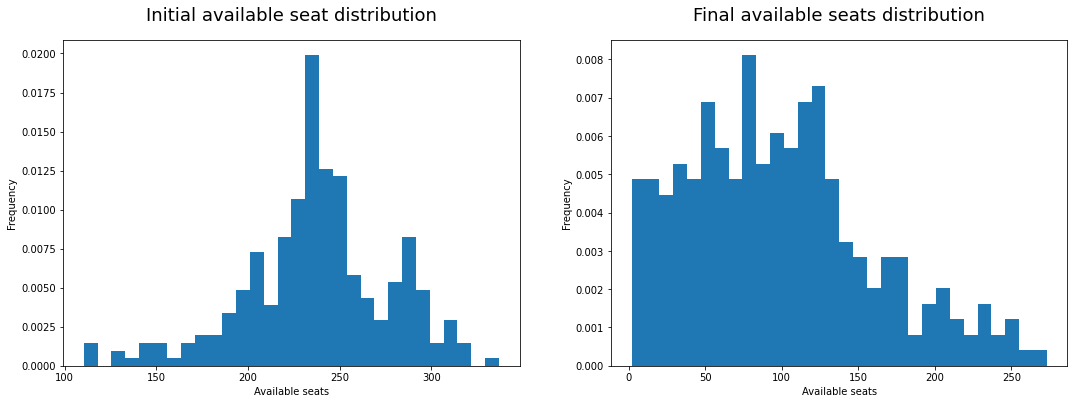

In [198]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "mean_econ_seats"
]

plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 2, 1)
#ax1.set_xlim(35, 110)
#ax1.set_ylim(0, 0.14)
ax1.hist(figdata.last(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Initial available seat distribution", fontsize=18, y=1.04)


ax3 = plt.subplot(1, 2, 2)
#ax3.set_xlim(35, 110)
#ax3.set_ylim(0, 0.14)
ax3.hist(figdata.first(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Final available seats distribution", fontsize=18, y=1.04)

plt.savefig("figures/price_distributions", dpi=300)

plt.show()

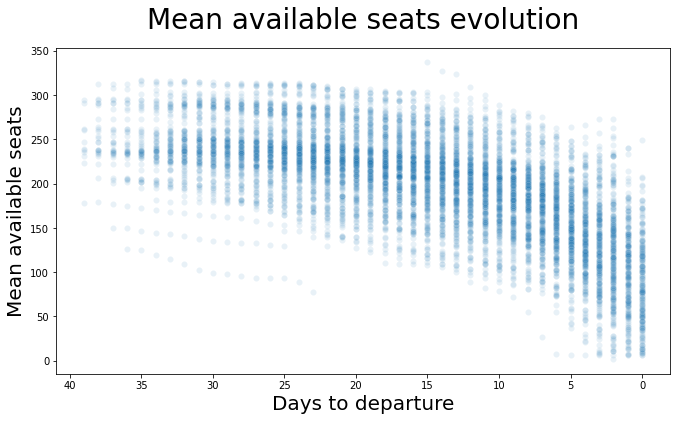

In [293]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    alpha=0.1
    #hue="train_id",
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

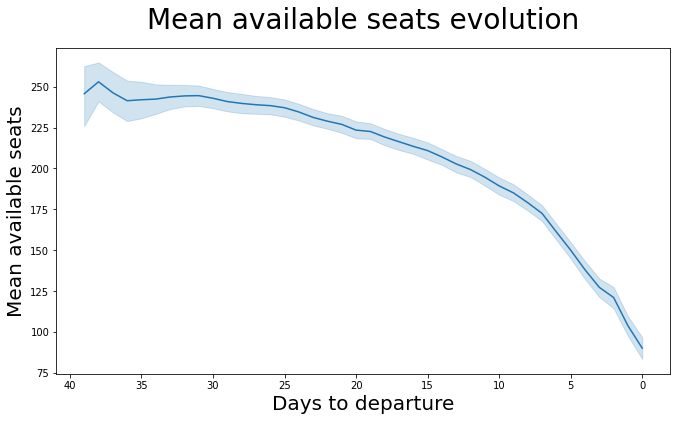

In [188]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.lineplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    estimator="mean",
    #hue="train_id",
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

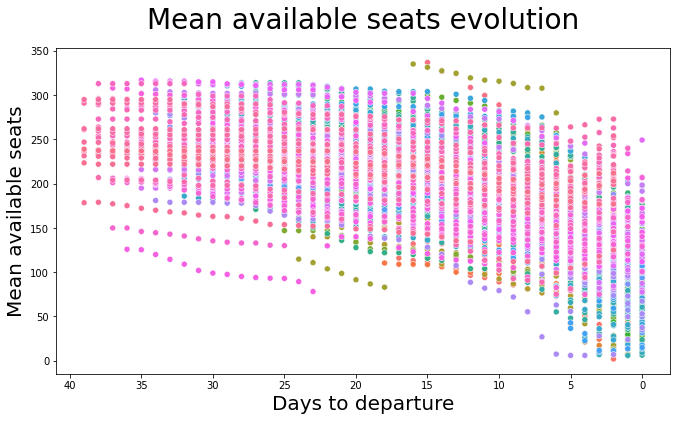

In [385]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    estimator="mean",
    hue="train_id",
).get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

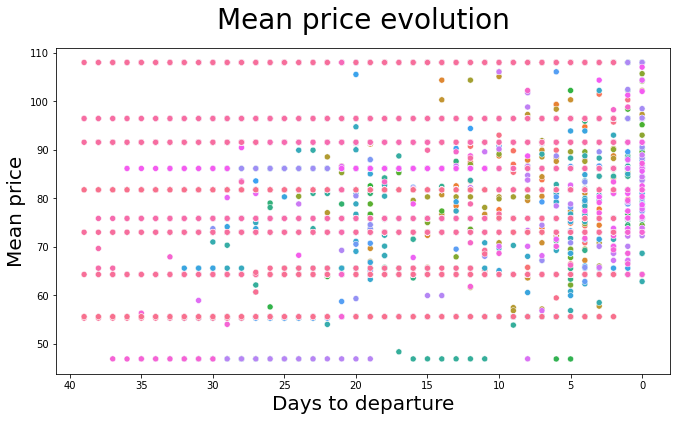

In [392]:
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data,
    x="days_till_dep",
    y="mean_econ_price",
    estimator="mean",
    hue="train_id",
).get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean price", fontsize=20, fontweight=450)

#plt.xlim(35,0)
#plt.ylim(75,90)

plt.title("Mean price evolution", fontsize=28, y=1.04)

plt.savefig("figures/mean price evolution", dpi=300)
plt.show()

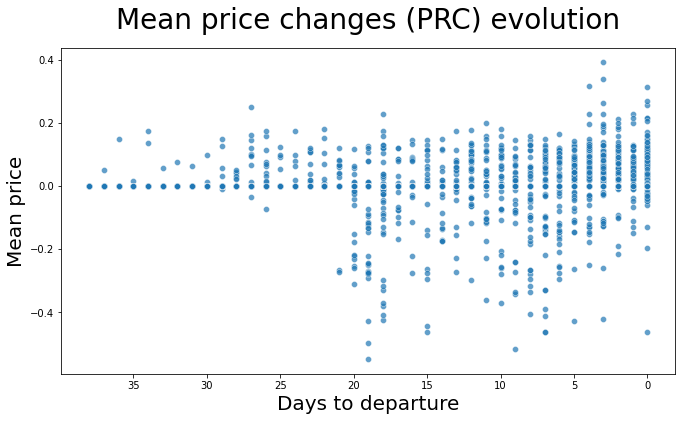

In [311]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    # hue="train_id",
    alpha=0.7,
)  # .get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean price change", fontsize=20, fontweight=450)

plt.title("Mean price changes (PRC) evolution", fontsize=28, y=1.04)

plt.savefig("figures/mean price (PRC) changes", dpi=300)
plt.show()

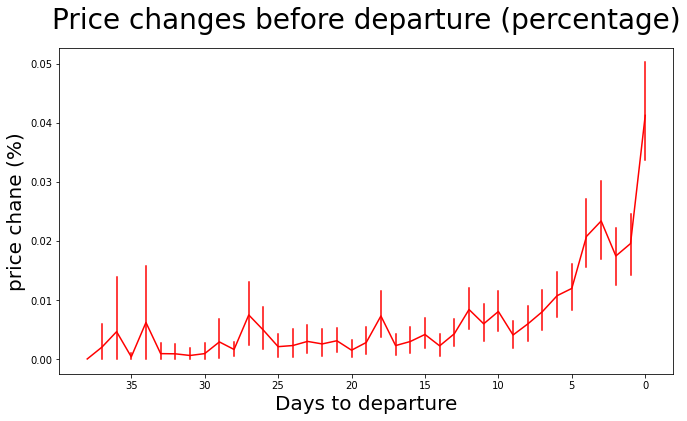

In [455]:
plt.figure(figsize=(11, 6))

sns.lineplot(
    data=data.loc[data["price_change_percentage"] >= 0],
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    color="red",
    
)


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("price chane (%)", fontsize=20, fontweight=450)

plt.title("Price changes before departure (percentage)", fontsize=28, y=1.04)

plt.savefig("figures/mean price (PRC) changes", dpi=300)
plt.show()

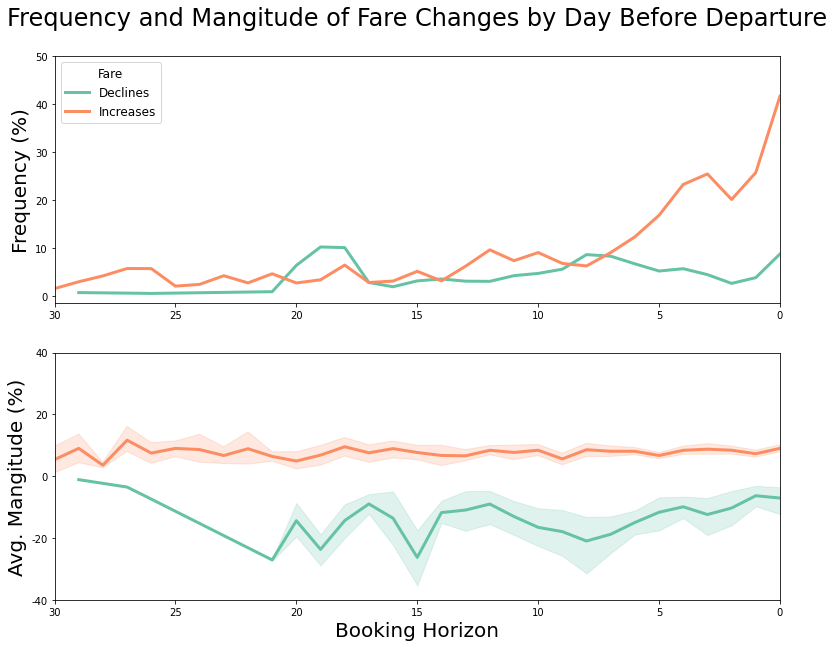

In [502]:
plt.figure(figsize=(13, 10))


figdata = (
    pd.DataFrame(data.groupby("days_till_dep")["price_change_direction"].value_counts())
    .rename(columns={"price_change_direction": "sum"})
    .reset_index()
)

figdata = figdata.merge(
    figdata.groupby("days_till_dep")["sum"]
    .sum()
    .reset_index()
    .rename(columns={"sum": "all"}),
    on="days_till_dep",
)

figdata["price_change_freq"] = figdata["sum"] / figdata["all"]

figdata = figdata.loc[figdata["price_change_direction"] != 0]

# TOP FIG.
ax1 = plt.subplot(2, 1, 1)

sns.lineplot(
    data=figdata,
    x="days_till_dep",
    y="price_change_freq",
    hue="price_change_direction",
    palette="Set2",
    linewidth=3,
    ax=ax1,
)

plt.gca().invert_xaxis()

plt.xlabel("", fontsize=0, fontweight=450)
plt.ylabel("Frequency (%)", fontsize=20, fontweight=450)
plt.title(
    "Frequency and Mangitude of Fare Changes by Day Before Departure",
    fontsize=24,
    y=1.1,
)


ax1.legend(
    ("Declines", "Increases"),
    loc="upper left",
    prop={"size": 12},
).set_title("Fare", prop={"size": 12})

tick_max = 0.5
tick_interval = 0.1
ax1.set_yticks(np.arange(0, tick_max + tick_interval, tick_interval))
ax1.set_yticklabels(np.arange(0, 60, 10))
ax1.set_xlim(30, 0)


# BOTTOM FIG.
figdata_2 = data.loc[data["price_change_direction"] != 0]

ax2 = plt.subplot(2, 1, 2)
sns.lineplot(
    data=figdata_2,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="price_change_direction",
    palette="Set2",
    linewidth=3,
    ax=ax2,
).get_legend().remove()

plt.gca().invert_xaxis()

plt.xlabel("Booking Horizon", fontsize=20, fontweight=450)
plt.ylabel("Avg. Mangitude (%)", fontsize=20, fontweight=450)


tick_max = 0.4
tick_min = -1 * tick_max
tick_interval = 0.2

ax2.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax2.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax2.set_xlim(30, 0)


plt.savefig("figures/freq_and_mang_of_fare_changes", dpi=300)
plt.show()

In [460]:
data.columns

Index(['level_0', 'index', 'train_id', 'days_till_dep', 'mean_econ_price',
       'mean_first_price', 'mean_price', 'max_econ_seats', 'min_econ_seats',
       'mean_econ_seats', 'max_first_seats', 'min_first_seats',
       'mean_first_seats', 'departure', 'duration', 'econ_seats_sold',
       'first_seats_sold', 'weekday', 'depart_month', 'depart_hour',
       'day_part', 'ln_price', 'ln_econ_seat', 'const', 'price_change',
       'price_change_percentage', 'price_change_direction'],
      dtype='object')

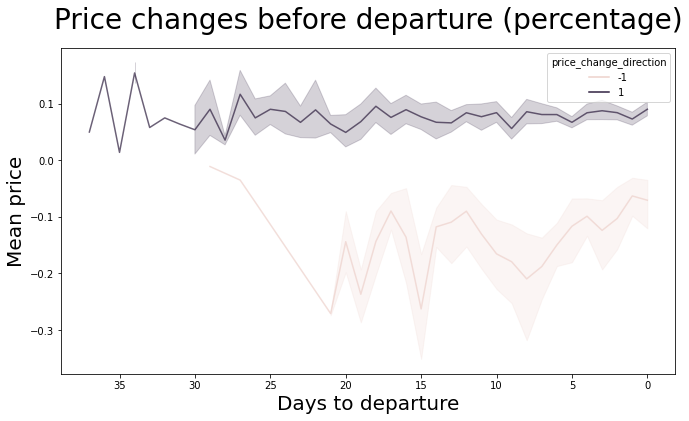

In [500]:

figdata = data.loc[data["price_change_direction"] != 0]


plt.figure(figsize=(11, 6))

sns.lineplot(
    data=figdata,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="price_change_direction",
    alpha=0.7,
)  # .get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean price", fontsize=20, fontweight=450)

plt.title("Price changes before departure (percentage)", fontsize=28, y=1.04)

plt.savefig("figures/price_changes_days_before_departure", dpi=300)
plt.show()

In [ ]:
data.loc[data["price_change_percentage"] != 0, "price_change_percentage"].hist(bins=100)

In [ ]:
sns.tsplot

In [ ]:
sns.scatterplot(data=data.loc[data["train_id"].isin(train_ids)],x="duration",y="ln_price",alpha=0.05)

# models

In [242]:
data = pd.read_pickle("data/MAD_BAR_features_v2.pkl")

In [243]:
data = pd.concat(
    [
        data[["train_id", "departure"]],
        data[data.columns.difference(["train_id", "departure"])].astype("float"),
    ],
    axis=1,
)

In [244]:
data_all = data.set_index(["train_id", "days_till_dep"])

In [246]:
fe_lm = PanelOLS.from_formula(
    "ln_price ~ ln_econ_seat + TimeEffects + EntityEffects",
    data_all,
    drop_absorbed=True,
).fit(cov_type="clustered", cluster_entity=True)

/usr/local/lib/python3.8/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


In [247]:
fe_lm.summary

Dep. Variable:,ln_price,R-squared:,0.0230
Estimator:,PanelOLS,R-squared (Between):,-0.0096
No. Observations:,7572,R-squared (Within):,0.0056
Date:,"Fri, Nov 27 2020",R-squared (Overall):,-0.0092
Time:,13:19:48,Log-likelihood,7508.3
Cov. Estimator:,Clustered,,
,,F-statistic:,170.76
Entities:,273,P-value,0.0000
Avg Obs:,27.736,Distribution:,"F(1,7259)"
Min Obs:,16.000,,
Max Obs:,38.000,F-statistic (robust):,90.082


In [227]:
data_all = data

In [228]:
data_all.loc[data_all["days_till_dep"] == 1].rename(
    columns={"ln_econ_seat": "ln_econ_seat_1"}
)[["train_id", "ln_econ_seat_1"]]

,train_id,ln_econ_seat_1
1,MADRIDBARCELONA2020-02-21 20:00:002020-02-21 2...,2.708050
32,MADRIDBARCELONA2020-02-22 10:30:002020-02-22 1...,3.912023
81,MADRIDBARCELONA2020-02-22 19:30:002020-02-22 2...,2.484907
98,MADRIDBARCELONA2020-02-23 06:20:002020-02-23 0...,2.302585
115,MADRIDBARCELONA2020-02-23 07:30:002020-02-23 1...,2.484907
...,...,...
9210,MADRIDBARCELONA2020-03-15 09:30:002020-03-15 1...,1.945910
9241,MADRIDBARCELONA2020-03-15 10:30:002020-03-15 1...,1.609438
9366,MADRIDBARCELONA2020-03-15 20:00:002020-03-15 2...,1.386294
9418,MADRIDBARCELONA2020-03-16 05:50:002020-03-16 0...,0.000000


In [229]:
i= 0

In [230]:
data_try = data_all.loc[data_all["days_till_dep"] == i].merge(
    data_all.loc[data_all["days_till_dep"] == i+1].rename(
        columns={"ln_econ_seat": "ln_econ_seat_1"}
    )[["train_id", "ln_econ_seat_1"]],
    on="train_id",
)

In [231]:
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

In [232]:
model = smf.ols(
    formula="ln_price ~ ln_econ_seat  + duration + weekday + depart_hour",
    data=data,
)
OLS_reg = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)

In [233]:
OLS_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     16.84
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           6.53e-40
Time:                        13:17:12   Log-Likelihood:                 4466.8
No. Observations:                7572   AIC:                            -8886.
Df Residuals:                    7548   BIC:                            -8719.
Df Model:                          23                                         
Covariance Type:              cluster                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.9749      0.102     48.580      0.000       4.774       5.176
weekday[T.1.0]         -0.0519      0.019     -2.755      0.006      -0.089      -0.015
weekday[T.2.0]         -0.0334      0.019     -1.714      0.086      -0.072       0.005
weekday[T.3.0]          0.0662      0.022      2.972      0.003       0.023       0.110
weekday[T.4.0]         -0.0020      0.025     -0.078      0.938      -0.051       0.047
weekday[T.5.0]          0.0106      0.024      0.450      0.653      -0.036       0.057
weekday[T.6.0]         -0.0873      0.034     -2.567      0.010      -0.154      -0.021
depart_hour[T.6.0]      0.1052      0.047      2.223      0.026       0.012       0.198
depart_hour[T.7.0]      0.2603      0.045      5.745      0.000       0.171       0.349
depart_hour[T.8.0]      0.1962      0.046      4.243      0.000       0.106       0.287
depart_hour[T.9.0]      0.2601      0.049      5.330      0.000       0.164       0.356
depart_hour[T.10.0]     0.3190      0.059      5.383      0.000       0.203       0.435
depart_hour[T.11.0]     0.2670      0.049      5.459      0.000       0.171       0.363
depart_hour[T.12.0]     0.2091      0.049      4.305      0.000       0.114       0.304
depart_hour[T.14.0]     0.1701      0.047      3.614      0.000       0.078       0.262
depart_hour[T.15.0]     0.1715      0.053      3.239      0.001       0.068       0.275
depart_hour[T.16.0]     0.2331      0.051      4.605      0.000       0.134       0.332
depart_hour[T.17.0]     0.2824      0.055      5.134      0.000       0.175       0.390
depart_hour[T.18.0]     0.1227      0.046      2.661      0.008       0.032       0.213
depart_hour[T.19.0]     0.2396      0.052      4.618      0.000       0.138       0.341
depart_hour[T.20.0]     0.1405      0.049      2.876      0.004       0.045       0.236
depart_hour[T.21.0]    -0.0980      0.066     -1.488      0.137      -0.227       0.031
ln_econ_seat           -0.0068      0.003     -2.387      0.017      -0.012      -0.001
duration               -0.2623      0.030     -8.838      0.000      -0.321      -0.204
==============================================================================
Omnibus:                       45.768   Durbin-Watson:                   0.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.496
Skew:                          -0.190   Prob(JB):                     8.01e-11
Kurtosis:                       2.943   Cond. No.                         82.0
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [234]:
data.loc[:, "days_till_dep"] = data.loc[:, "days_till_dep"].astype("category")
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")
IV_reg = IVGMM(
    data["ln_price"],
    data[["const", "days_till_dep", "duration"]],
    data["ln_econ_seat"],
    data[["weekday", "depart_hour"]],
).fit(
    cov_type="kernel",
    # cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)
IV_reg.summary

/usr/local/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               ln_price   R-squared:                     -0.2354
Estimator:                     IV-GMM   Adj. R-squared:                -0.2421
No. Observations:                7572   F-statistic:                 1.414e+04
Date:                Fri, Nov 27 2020   P-value (F-stat)                0.0000
Time:                        13:17:32   Distribution:                 chi2(41)
Cov. Estimator:                kernel                                         
                                                                              
                                 Parameter Estimates                                  
======================================================================================
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
const                  4.8741     0.1388     35.127     0.0000      4.6021      5.1460
days_till_dep.1.0      0.0136     0.0195     0.6962     0.4863     -0.0247      0.0519
days_till_dep.2.0      0.0437     0.0385     1.1348     0.2564     -0.0318      0.1193
days_till_dep.3.0      0.0273     0.0391     0.6989     0.4846     -0.0493      0.1040
days_till_dep.4.0     -0.0174     0.0358    -0.4862     0.6268     -0.0875      0.0527
days_till_dep.5.0     -0.0308     0.0373    -0.8241     0.4099     -0.1039      0.0424
days_till_dep.6.0     -0.0268     0.0393    -0.6820     0.4952     -0.1038      0.0502
days_till_dep.7.0     -0.0047     0.0425    -0.1095     0.9128     -0.0880      0.0787
days_till_dep.8.0      0.0410     0.0628     0.6527     0.5139     -0.0821      0.1640
days_till_dep.9.0      0.0710     0.0782     0.9079     0.3639     -0.0822      0.2242
days_till_dep.10.0     0.0706     0.0765     0.9227     0.3562     -0.0793      0.2204
days_till_dep.11.0     0.0718     0.0817     0.8789     0.3794     -0.0883      0.2319
days_till_dep.12.0     0.0653     0.0781     0.8363     0.4030     -0.0878      0.2184
days_till_dep.13.0     0.0657     0.0745     0.8820     0.3778     -0.0803      0.2118
days_till_dep.14.0     0.0885     0.0822     1.0767     0.2816     -0.0726      0.2497
days_till_dep.15.0     0.0928     0.0871     1.0662     0.2863     -0.0778      0.2635
days_till_dep.16.0     0.1196     0.0951     1.2579     0.2084     -0.0668      0.3060
days_till_dep.17.0     0.1193     0.0939     1.2699     0.2041     -0.0648      0.3034
days_till_dep.18.0     0.1009     0.0818     1.2339     0.2173     -0.0594      0.2613
days_till_dep.19.0     0.1009     0.0811     1.2435     0.2137     -0.0581      0.2599
days_till_dep.20.0     0.1412     0.0927     1.5235     0.1276     -0.0405      0.3229
days_till_dep.21.0     0.1624     0.0962     1.6884     0.0913     -0.0261      0.3508
days_till_dep.22.0     0.1708     0.0993     1.7199     0.0855     -0.0238      0.3653
days_till_dep.23.0     0.1814     0.1046     1.7346     0.0828     -0.0236      0.3863
days_till_dep.24.0     0.1691     0.1008     1.6768     0.0936     -0.0285      0.3667
days_till_dep.25.0     0.1586     0.0996     1.5918     0.1114     -0.0367      0.3539
days_till_dep.26.0     0.1612     0.0953     1.6909     0.0909     -0.0256      0.3479
days_till_dep.27.0     0.1879     0.0990     1.8978     0.0577     -0.0062      0.3819
days_till_dep.28.0     0.1629     0.0964     1.6907     0.0909     -0.0259      0.3518
days_till_dep.29.0     0.1859     0.1040     1.7865     0.0740     -0.0180      0.3898
days_till_dep.30.0     0.1868     0.1047     1.7851     0.0742     -0.0183      0.3920
days_till_dep.31.0     0.1654     0.0972     1.7020     0.0888     -0.0251      0.3559
days_till_dep.32.0     0.1774     0.1052     1.6860     0.0918     -0.0288      0.3836
days_till_dep.33

In [248]:
data = pd.read_pickle("data/MAD_BAR_features_v2.pkl")

data["price_change"] = data.groupby("train_id")["mean_price"].transform("diff")

train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:105, "train_id"]
    .values
)
data = data.loc[data["train_id"].isin(train_ids)]

data["days_till_dep"] = data["days_till_dep"].astype(int)
data = data.loc[data["days_till_dep"] < 15].reset_index(drop=True)

data.loc[:, "days_till_dep"] = data.loc[:, "days_till_dep"].astype("category")
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")
IV_reg = IVGMM(
    data["ln_price"],
    data[["const", "days_till_dep", "duration"]],
    data["ln_econ_seat"],
    data[["weekday", "depart_hour"]],
).fit(
    cov_type="kernel",
    # cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)
IV_reg.summary

/usr/local/lib/python3.8/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:               ln_price   R-squared:                      0.1606
Estimator:                     IV-GMM   Adj. R-squared:                 0.1515
No. Observations:                1502   F-statistic:                    2015.0
Date:                Fri, Nov 27 2020   P-value (F-stat)                0.0000
Time:                        13:20:43   Distribution:                 chi2(16)
Cov. Estimator:                kernel                                         
                                                                              
                                Parameter Estimates                                 
====================================================================================
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                5.1846     0.1534     33.787     0.0000      4.8839      5.4854
days_till_dep.1     -0.0223     0.0125    -1.7835     0.0745     -0.0468      0.0022
days_till_dep.2     -0.0286     0.0224    -1.2767     0.2017     -0.0726      0.0153
days_till_dep.3     -0.0410     0.0218    -1.8766     0.0606     -0.0838      0.0018
days_till_dep.4     -0.0598     0.0198    -3.0244     0.0025     -0.0985     -0.0210
days_till_dep.5     -0.0767     0.0176    -4.3654     0.0000     -0.1111     -0.0423
days_till_dep.6     -0.0897     0.0204    -4.3897     0.0000     -0.1297     -0.0496
days_till_dep.7     -0.0967     0.0281    -3.4433     0.0006     -0.1517     -0.0416
days_till_dep.8     -0.1078     0.0405    -2.6628     0.0078     -0.1871     -0.0284
days_till_dep.9     -0.1123     0.0451    -2.4872     0.0129     -0.2008     -0.0238
days_till_dep.10    -0.1158     0.0420    -2.7558     0.0059     -0.1981     -0.0334
days_till_dep.11    -0.1245     0.0466    -2.6701     0.0076     -0.2159     -0.0331
days_till_dep.12    -0.1307     0.0427    -3.0632     0.0022     -0.2143     -0.0471
days_till_dep.13    -0.1301     0.0419    -3.1031     0.0019     -0.2123     -0.0479
days_till_dep.14    -0.1146     0.0537    -2.1355     0.0327     -0.2197     -0.0094
duration            -0.2393     0.0309    -7.7423     0.0000     -0.2998     -0.1787
ln_econ_seat         0.0119     0.0256     0.4647     0.6421     -0.0382      0.0620
====================================================================================

Endogenous: ln_econ_seat
Instruments: weekday.1, weekday.2, weekday.3, weekday.4, weekday.5, weekday.6, depart_hour.6, depart_hour.7, depart_hour.8, depart_hour.9, depart_hour.10, depart_hour.11, depart_hour.12, depart_hour.14, depart_hour.15, depart_hour.16, depart_hour.17, depart_hour.18, depart_hour.19, depart_hour.20, depart_hour.21
GMM Covariance
Debiased: False
Kernel (HAC)
Kernel: bartlett
Bandwidth: 1500
"""

In [ ]:
sns.lineplot(data=pd.DataFrame(IV_reg.params.iloc[1:-2]).reset_index())
plt.gca().invert_xaxis()

In [ ]:
data_all = data_all.reset_index()

In [235]:
dic_estimate = {}
dic_confidence = {}
for i in range(0, 30):
    data = data_all.loc[data_all["days_till_dep"] == i].merge(
        data_all.loc[data_all["days_till_dep"] == i + 1].rename(
            columns={"ln_econ_seat": "ln_econ_seat_1"}
        )[["train_id", "ln_econ_seat_1"]],
        on="train_id",
    )
    data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
    data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

    IV_reg = IVGMM(
        data["ln_price"],
        data[["const", "duration"]],
        data["ln_econ_seat"],
        data[["weekday", "depart_hour"]],
    ).fit()

    dic_estimate[i] = IV_reg.params["ln_econ_seat"]
    dic_confidence[i] = IV_reg.conf_int().loc["ln_econ_seat"].values

<ipython-input-236-c50da3f670be>:18: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot("index", "x", data=estimates, color="black", linewidth=1.5)


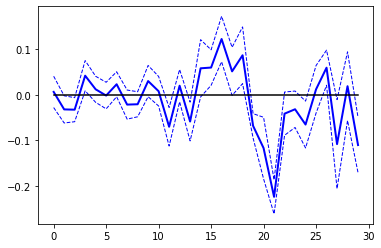

In [236]:
estimates = pd.concat(
    [
        pd.DataFrame(dic_confidence).T.rename(columns={0: "lower", 1: "upper"}),
        pd.DataFrame(dic_estimate.values()).rename(columns={0: "estimate"}),
    ],
    axis=1,
).reset_index()

estimates = estimates.loc[0:30, :]
estimates["x"] = 0
plt.plot("index", "estimate", data=estimates, color="blue", linewidth=2)
plt.plot(
    "index", "lower", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot(
    "index", "upper", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot("index", "x", data=estimates, color="black", linewidth=1.5)

In [ ]:
 ln_econ_seat.shift(1) + ln_econ_seat.shift(2)

In [237]:
dic_estimate = {}
dic_confidence = {}

for i in range(0, 30):
    data = data_all.loc[data_all["days_till_dep"] == i].merge(
        data_all.loc[data_all["days_till_dep"] == i + 1].rename(
            columns={"ln_econ_seat": "ln_econ_seat_1"}
        )[["train_id", "ln_econ_seat_1"]],
        on="train_id",
    )
    data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
    data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

    model = smf.ols(
        formula="ln_price ~ ln_econ_seat + ln_econ_seat_1 + duration + weekday + depart_hour",
        data=data,
    )
    OLS_reg = model.fit(
        cov_type="cluster",
        cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
    )

    variable = "ln_econ_seat"

    dic_estimate[i] = OLS_reg.params[variable]
    dic_confidence[i] = OLS_reg.conf_int().loc[variable].values

<ipython-input-238-2abcc135c04f>:18: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot("index","x", data=estimates, color="black", linewidth=1.5)


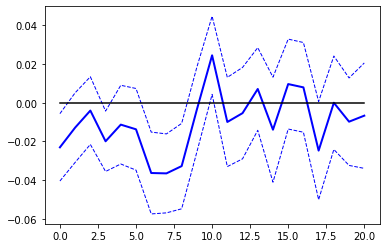

In [238]:
estimates = pd.concat(
    [
        pd.DataFrame(dic_confidence).T.rename(columns={0: "lower", 1: "upper"}),
        pd.DataFrame(dic_estimate.values()).rename(columns={0: "estimate"}),
    ],
    axis=1,
).reset_index()

estimates = estimates.loc[0:20, :]
estimates["x"] = 0
plt.plot("index", "estimate", data=estimates, color="blue", linewidth=2)
plt.plot(
    "index", "lower", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot(
    "index", "upper", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot("index","x", data=estimates, color="black", linewidth=1.5)